# Proyecto Final
## Recomendador de películas.

Realizado por: **Álvaro González Rodríguez**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

Abrimos los dos datasets que vamos a analizar en este proyecto. Se han escogidos los dos datasets iniciales que se nos entregaron al inicio del curso, pues hemos adquirido más práctica conforme hemos avanzado y además estos datasets presentan más datos que el que se nos dió más adelante.

In [2]:
rawmovies = pd.read_csv('../ml-latest-small/movies.csv',sep=",")
rawratings = pd.read_csv('../ml-latest-small/ratings.csv',sep=",")

**Leyenda de los dataset:**
- moviesId = Identificador de película (cada una tiene la suya)
- title = Título de la película
- genres = Género de la película
- rating = Valoración dada por un usuario a una película
- timestamp = Fecha

# 1. Preprocesamiento de los datos

In [3]:
print(rawmovies.shape)
rawmovies.head(5)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(rawratings.shape)
rawratings.head(5)

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Definimos una función que nos devuelve el % de valores nulos de un dataset:

In [5]:
def Percent_NaN(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent1 = dataset.isnull().sum()/dataset.isnull().count()*100
    percent2 = (round(percent1,1)).sort_values(ascending=False)
    missing_data = pd.concat([total,percent2],\
                             axis=1,\
                             keys=['Count', '% NaN'])
    return missing_data

In [6]:
print(Percent_NaN(rawmovies),"\n")
print(Percent_NaN(rawratings),"\n")

         Count  % NaN
genres       0    0.0
title        0    0.0
movieId      0    0.0 

           Count  % NaN
timestamp      0    0.0
rating         0    0.0
movieId        0    0.0
userId         0    0.0 



Ninguno de los dos dataset presentan valores nulos.

Comprobamos los distintos géneros que presentan las películas en el dataset *rawmovies*. Estos géneros están separados por el carácter '|', por lo que tendremos que usar la función *.split()*. Después, serán guardados en una lista con la función *.extend()*.

In [7]:
new = []
for genre in rawmovies['genres']:
    new.extend(genre.split('|'))
genres = sorted(set(new), reverse=False)
print('Generos de las películas: \n',genres)

Generos de las películas: 
 ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


Vemos que existe un valor '(no genres listed)'. Este es equivalente a un NaN, por lo que tendremos que eliminar las películas que presenten este género.

A continuación comprobamos la cantidad de *movieId* y *title* distintos del dataset movies. Vemos que existen más *movieId* que *title*, por lo que hay películas repetidas.

In [8]:
print('Tamaño de la tabla: ',rawmovies.shape,\
      "\nMovieId distintos: ", len(rawmovies['movieId'].unique()),\
      "\nPeliculas distintas: ", len(rawmovies['title'].unique()))

veces_pelicula = rawmovies.groupby('title')['movieId'].agg(repeticiones='count').reset_index()

#Peliculas que se repiten:
repetidas = veces_pelicula[veces_pelicula['repeticiones'] > 1]

#El genero indicado no es el mismo. Nuestro criterio sera quedarnos con la pelicula con genero mas largo.
#Nos vale solo con quedarnos el index de esas peliculas y luego eliminarlas del dataset inicial.
peliculas_repetidas = rawmovies[rawmovies['title'].isin(repetidas.title)].sort_values('title',ascending=False)
print('\nPeliculas que estan repetidas:')
peliculas_repetidas

Tamaño de la tabla:  (9742, 3) 
MovieId distintos:  9742 
Peliculas distintas:  9737

Peliculas que estan repetidas:


,movieId,title,genres
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller


Los objetivos principales en la limpieza de los datos será eliminar las películas repetidas y aquellas con el género: *(no genres listed)*

# 2. Limpieza del dataset *ratings.csv*

El objetivo de este apartado es eliminar valores erróneos. Del apartado anterior hemos visto que hay películas catalogadas como "no genres listed" y un pequeño subconjunto repetidas. 
Tendremos que guardar el Id de la película, pues tendremos que eliminarlas también en el dataset *ratings.csv*.

In [9]:
print('Películas diferentes:', rawratings['movieId'].unique().shape[0])
rawratings

Películas diferentes: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Eliminamos la columna 'timestamp', pues no aporta información relevante.

In [10]:
rawratings.drop(labels=['timestamp'],axis=1,inplace=True)

### - Eliminamos las películas sin género (en el dataset ratings):

Como hemos dicho, hay que eliminar el subconjunto de películas que no presentan género. En vez de aparecer como NaN, aparecen como '(no genres listed)'.

In [11]:
peliculas_sin_genero = rawmovies[rawmovies['genres']=='(no genres listed)']
print('Numero de peliculas sin genero: ',len(peliculas_sin_genero.movieId.unique()))
if(len(peliculas_sin_genero.movieId.unique()) == len(peliculas_sin_genero.title.unique())):
    print('**No hay peliculas repetidas con este genero')
peliculas_sin_genero.head(5)

Numero de peliculas sin genero:  34
**No hay peliculas repetidas con este genero


,movieId,title,genres
8517,114335,La cravate (1957),(no genres listed)
8684,122888,Ben-hur (2016),(no genres listed)
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
8782,129250,Superfast! (2015),(no genres listed)
8836,132084,Let It Be Me (1995),(no genres listed)


In [12]:
# Eliminamos las peliculas en rawratings con movieId iguales que esten en peliculas_sin_genero.
rawratings = rawratings[rawratings['movieId'].isin(peliculas_sin_genero['movieId'])==False]
rawratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### - Eliminamos las películas repetidas:

Recordamos cual era el subconjunto de películas repetidas:

In [13]:
peliculas_repetidas

,movieId,title,genres
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller


Comprobamos cuántas veces han sido valoradas las películas repetidas. El **criterio** que seguiremos será **quedarnos con las películas que tengan más valoraciones.**

In [14]:
valoraciones_peliculas_repetidas = rawratings[rawratings['movieId'].isin(peliculas_repetidas['movieId'])].sort_values('movieId', ascending=True)

# Fusionamos con peliculas_repetidas para tener los titulos
valoraciones_peliculas_repetidas = valoraciones_peliculas_repetidas.merge(peliculas_repetidas, on='movieId')
valoraciones_peliculas_repetidas

,userId,movieId,rating,title,genres
0,104,838,4.0,Emma (1996),Comedy|Drama|Romance
1,500,838,3.0,Emma (1996),Comedy|Drama|Romance
2,246,838,4.0,Emma (1996),Comedy|Drama|Romance
3,489,838,3.0,Emma (1996),Comedy|Drama|Romance
4,488,838,5.0,Emma (1996),Comedy|Drama|Romance
...,...,...,...,...,...
101,68,64997,2.5,War of the Worlds (2005),Action|Sci-Fi
102,28,64997,3.5,War of the Worlds (2005),Action|Sci-Fi
103,111,144606,4.0,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
104,318,147002,4.0,Eros (2004),Drama|Romance


In [15]:
veces_valorada_peliculas_repetidas = valoraciones_peliculas_repetidas.groupby('movieId')['movieId'].agg(veces_valorada='count')

# Fusionamos con peliculas_repetidas para tener los titulos
veces_valoraciones_peliculas_repetidas = veces_valorada_peliculas_repetidas.merge(peliculas_repetidas, on='movieId').sort_values('title', ascending=False)
veces_valoraciones_peliculas_repetidas = veces_valoraciones_peliculas_repetidas.set_index('movieId')
veces_valoraciones_peliculas_repetidas

,veces_valorada,title,genres
movieId,,,
34048,50,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
64997,2,War of the Worlds (2005),Action|Sci-Fi
2851,4,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
168358,1,Saturn 3 (1980),Sci-Fi|Thriller
32600,1,Eros (2004),Drama
147002,1,Eros (2004),Drama|Romance
838,30,Emma (1996),Comedy|Drama|Romance
26958,1,Emma (1996),Romance
6003,15,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller


In [16]:
# Guardamos las peliculas buenas. Las usaremos para conocer las peliculas que queremos eliminar. 
# Lo hacemos asi para darle mayor generalidad al codigo. Si hubiera alguna pelicula con 3 generos distintos (repetida 3
# veces) no nos valdria con eliminar la pelicula con valor minimo de 'veces_valorada'.
idxbuenos = []
for title in set(veces_valoraciones_peliculas_repetidas['title']):
    idxbuenos.append(veces_valoraciones_peliculas_repetidas[veces_valoraciones_peliculas_repetidas['title']==title]['veces_valorada'].idxmax())

# Los indices a eliminar son todos aquellos que no sean 'idxbuenos'
idxeliminar = veces_valoraciones_peliculas_repetidas[veces_valoraciones_peliculas_repetidas.index.isin(idxbuenos) == False].index

# Eliminamos del dataset 'rawratings'
ratings = rawratings[rawratings['movieId'].isin(idxeliminar)==False].reset_index(drop=True)
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100778,610,166534,4.0
100779,610,168248,5.0
100780,610,168250,5.0
100781,610,168252,5.0


### Dataset *ratings* limpio:

In [17]:
# Guardamos estos datos en un archivo .csv nuevo:
ratings.to_csv('./cleaned_ratings.csv', sep=',', index=False)

In [18]:
print('Películas diferentes:', len(ratings['movieId'].unique()))
ratings

Películas diferentes: 9685


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100778,610,166534,4.0
100779,610,168248,5.0
100780,610,168250,5.0
100781,610,168252,5.0


# 3. Limpieza del dataset *movies.csv*

In [19]:
print('Películas diferentes:', len(rawmovies['movieId'].unique()))
rawmovies.head(4)

Películas diferentes: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance


**Eliminamos las películas sin género**

Como hemos dicho, hay que eliminar el subconjunto de películas que no presentan género. En vez de aparecer como NaN, aparece como '(no genres listed)'.

In [20]:
# Eliminamos las peliculas en rawmovies con movieId iguales que esten en peliculas_sin_genero.
rawmovies = rawmovies[rawmovies['genres'] != '(no genres listed)']
rawmovies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


**Eliminamos las películas repetidas**

Hay películas repetidas con distinto valor de *movieId* y género. Nuestro criterio será quedarnos con las películas con más valoraciones. (Como hicimos con el dataset *ratings*)

In [21]:
# Eliminamos las peliculas repetidas siguiendo el criterio establecido.
# Usaremos los indices 'idxeliminar' que ya conociamos.
movies = rawmovies[rawmovies['movieId'].isin(idxeliminar)==False].reset_index(drop=True)

### Dataset *movies* limpio:

In [22]:
# Guardamos estos datos en un archivo .csv nuevo:
movies.to_csv('./cleaned_movies.csv', sep=',', index=False)

In [23]:
print('Películas diferentes:', movies['movieId'].unique().shape[0])
movies

Películas diferentes: 9703


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9698,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9699,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9700,193585,Flint (2017),Drama
9701,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Es curioso ver que el dataset ***movies*** tiene **9703 películas diferentes** y el dataset ***ratings*** tiene **9685 películas diferentes**. En principio ambos datasets deberían ser del mismo tamaño, ¿es posible que los datos que se nos han dado ya venían con un pequeño preprocesamiento? porque no teníamos ningún NaN por ejemplo.

In [24]:
# ¿Que peliculas no han sido evaluadas?
print('Las siguientes peliculas no han sido valoradas por los usuarios: ')
movies[movies['movieId'].isin(ratings['movieId'])==False]

Las siguientes peliculas no han sido valoradas por los usuarios: 


,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War
4037,5721,"Chosen, The (1981)",Drama
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
4598,6849,Scrooge (1970),Drama|Fantasy|Musical
4704,7020,Proof (1991),Comedy|Drama|Romance
5020,7792,"Parallax View, The (1974)",Thriller


### Fusión de ambos datasets:

Llegado a este punto, podemos fusionar ambos datasets: *movies* y *ratings*. La tabla resultante sería aquella donde las películas formarían las columnas, los usuarios las filas y los valores de cada elemento de la matriz las puntuaciones aportadas por los usuarios. 

In [25]:
ratings = pd.read_csv("./cleaned_ratings.csv", sep=',', usecols=['userId', 'movieId', 'rating'])
ratings

movies = pd.read_csv('./cleaned_movies.csv', usecols=['movieId', 'title'])
ratings

# Combinamos ambos datasets
movieratings = pd.merge(movies, ratings, on=['movieId'])
movieratings

# Pivotamos la tabla para que la matriz tenga : fila por usuario y columna por pelicula
movieratings = movieratings.pivot_table(index=['userId'], columns=['title'], values='rating')  

# Sustituimos los valores NaN por ceros:
movieratings = movieratings.fillna(0)
movieratings

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


Guardaremos esta tabla en un archivo .csv nuevo:

In [26]:
movieratings.to_csv('cleaned_movieratings.csv', sep=',', index=False)

# 4. Visualización de los datos

En este apartado realizaremos un par de gráficas para visualizar los datos y llegar a comprenderlos mejor.

Añadimos un gráfico con el número de evaluaciones que ha realizado cada usuario, con el objetivo de demostrar que si juntamos las tablas *movies* y *ratings* existirán muchos NaN.

In [27]:
# Vemos cuántas valoraciones ha hecho cada usuario:
count_ratings_user = ratings.groupby(by='userId')['movieId']\
                            .agg(count_rating='count')\
                            .reset_index()\
                            .sort_values(by='count_rating',ascending=False)
count_ratings_user

,userId,count_rating
413,414,2696
598,599,2474
473,474,2108
447,448,1862
273,274,1346
...,...,...
441,442,20
568,569,20
319,320,20
575,576,20


In [28]:
ymax = count_ratings_user['count_rating'].max()
xmax = count_ratings_user[count_ratings_user['count_rating']==ymax]['userId']

grafico = alt.Chart(count_ratings_user).mark_bar().encode(x='userId:O',\
                                                          y='count_rating',\
                                                          color=alt.condition(alt.datum.userId == int(xmax),\
                                                                              alt.value('red'),\
                                                                              alt.value('steelblue')\
                                                                              ),\
                                                          tooltip=['userId','count_rating'])\
                                                  .interactive()\
                                                  .properties(width=len(count_ratings_user)*1.45)\
                                                  .configure_axis(titleFontSize=15)
grafico

alt.Chart(...)

In [29]:
# Vemos cuántas valoraciones tiene cada película:
count_ratings_film = ratings.groupby(by='movieId')['movieId'].agg(count_rating='count').reset_index()
mean_ratings_film = ratings.groupby(by='movieId')['rating'].agg(mean_rating='mean').reset_index()

# Les añadimos los títulos a las películas:
count_ratings_film = pd.merge(count_ratings_film, movies[['title', 'movieId']], on='movieId')
count_mean_ratings_film = pd.merge(mean_ratings_film, count_ratings_film, on='movieId')
count_mean_ratings_film

,movieId,mean_rating,count_rating,title
0,1,3.920930,215,Toy Story (1995)
1,2,3.431818,110,Jumanji (1995)
2,3,3.259615,52,Grumpier Old Men (1995)
3,4,2.357143,7,Waiting to Exhale (1995)
4,5,3.071429,49,Father of the Bride Part II (1995)
...,...,...,...,...
9680,193581,4.000000,1,Black Butler: Book of the Atlantic (2017)
9681,193583,3.500000,1,No Game No Life: Zero (2017)
9682,193585,3.500000,1,Flint (2017)
9683,193587,3.500000,1,Bungo Stray Dogs: Dead Apple (2018)


Nos planteamos representar los datos de *mean rating* frente a *count rating*. Para ello, vamos a realizar un *JointGrid* de la biblioteca *Seaborn*. Con *JointGrid* podemos representar tres gráficas en una. En nuestro caso, realizaremos un histograma en cada eje y en el centro presentaremos un *scatterplot*.

Para tener más flexibilidad a la hora de fijar los parámetros hemos fijado primero los parámetros del JointGrid y luego hemos especificado con *plot_joint*, *ax_marg_{x,y}* los tipos de gráficos que deseabamos en cada parte. (El primero para el centro y los dos últimos para los ejes X e Y).

Por último se fijan los tamaños de las etiquetas y números de los ejes.

Los colores se han obtenido de esta referencia: https://xkcd.com/color/rgb/ (hay que usar *sns.xkcd_rgb[]*)

Se ha añadido la opción de que la gráfica sea interactiva mediante: *%matplotlib nbagg*

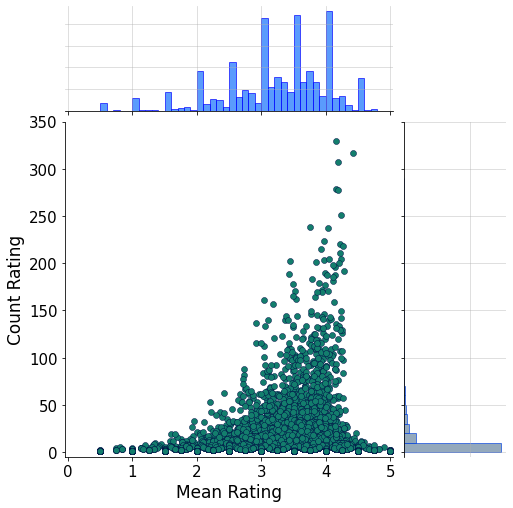

In [30]:
chart = sns.JointGrid(data=count_mean_ratings_film, \
                      x='mean_rating',\
                      y='count_rating',\
                      space=0.1,\
                      height=7,\
                      ratio=3,\
                      xlim=(-0.05,5.05),\
                      ylim=(-5,350))
chart.plot_joint(sns.scatterplot, color=sns.xkcd_rgb['blue green'], edgecolor=sns.xkcd_rgb['navy blue'])

chart.ax_marg_x.hist(count_mean_ratings_film['mean_rating'],\
                     color=sns.xkcd_rgb['bright blue'],\
                     edgecolor='blue',\
                     bins=np.arange(0,5,0.1),\
                     alpha=0.65)

chart.ax_marg_y.hist(count_mean_ratings_film['count_rating'],\
                     color=sns.xkcd_rgb['slate blue'],\
                     edgecolor=sns.xkcd_rgb['blue'],\
                     bins=np.arange(0,300,10),\
                     orientation='horizontal',\
                     alpha=0.65)

chart.set_axis_labels(xlabel='Mean Rating',\
                      ylabel='Count Rating',\
                      fontsize=17)

plt.tick_params(axis='both', labelsize=15)
chart.ax_marg_x.grid(True, alpha=0.5)
chart.ax_marg_y.grid(True, alpha=0.5)

La intención de representar los datos del promedio de la puntuación con el número de veces que se ha puntuado esa película es demostrar que el promedio de una película solo es válido si en esta hay muchas puntuaciones. Es decir, solo aquellas películas que tengan un *count rating* grande (>50 o >100) tendrán un *mean rating* válido.

Si nos fijamos en los datos, las películas que han sido valoradas muchas veces presentan un valor promedio en su puntuación entre 2.5 y 4.5. (Aunque es verdad que habría que fijarse en la distribución que siguen las valoraciones de una misma película y ver si presentan outliers. En ese caso podríamos guiarnos por la mediana en vez de por la media).

# 5. Filtrado colaborativo de contenido

Una vez tenemos ambos datasets limpios, podemos proceder al análisis de estos.

El objetivo en este apartado es crear la matriz de similitud entre las películas para ver cómo se relacionan estas.

Usaremos la lista *genres* como condición para crear una matriz de 1 y 0 donde las filas serán las películas y las columnas los géneros posibles. Habrá un 1 si la película presenta ese género y un 0 en caso contrario.

In [31]:
movies = pd.read_csv('./cleaned_movies.csv', sep=',')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9698,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9699,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9700,193585,Flint (2017),Drama
9701,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Crearemos un DataFrame con los nombres de las películas en las columnas y los géneros en las filas. Los valores serán 1 o 0 si la película presenta ese género o no.

In [32]:
# Aprovechamos la variable lista de generos de las peliculas, le eliminamos el elemento '(no genres listed)'
# puesto que hemos eliminado esas peliculas.
genres.remove('(no genres listed)')

# Definimos un  dataframe lleno de ceros. Luego cambiaremos por 1 en donde se cumpla la condición.
zeros = np.zeros(shape=(len(genres),len(movies)))
df_movies_genres = pd.DataFrame(zeros, index=genres, columns=movies['title'])

# Nos movemos por toda la columna de géneros:
for genre_film, title_film in zip(movies['genres'], movies['title']):
    
    # Separamos los géneros de la película. Asignamos un 1 en esas columnas.
    genre_film = genre_film.split('|')
    for genre in genre_film:
        df_movies_genres.loc[(genre,title_film)]= 1

In [33]:
df_movies_genres

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
Action,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Adventure,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Animation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
Children,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comedy,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
Crime,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Documentary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Drama,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Fantasy,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Film-Noir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Guardaremos en un archivo .csv estos datos, para así evitarnos en un futuro tener que volver a hacer este preprocesamiento.

In [34]:
df_movies_genres.to_csv('movies_genres.csv', sep=',', index=False)

Ahora podemos crear la matriz de correlación. Esta matríz correlacionará las películas según sus géneros. Devolverá valores altos para películas con géneros parecidos y valores cercanos a cero o negativos en aquellas películas que no presenten géneros en común.

Puesto que tenemos 9703 películas diferentes, las dimensiones de la matriz serán 9703x9703.

In [35]:
films_correlation = pd.DataFrame(np.corrcoef(df_movies_genres, \
                                             rowvar=False),\
                                 columns = df_movies_genres.columns,\
                                 index = df_movies_genres.columns)

In [36]:
films_correlation

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.724569,0.184482,0.069007,0.394405,-0.258775,0.184482,0.573944,-0.140859,0.069007,...,0.277746,0.184482,0.184482,0.394405,-0.140859,0.570922,0.724569,-0.140859,0.184482,0.394405
Jumanji (1995),0.724569,1.000000,-0.148522,-0.187500,-0.102062,-0.187500,-0.148522,0.792118,-0.102062,0.208333,...,-0.223607,-0.148522,-0.148522,-0.102062,-0.102062,0.130437,0.208333,-0.102062,-0.148522,-0.102062
Grumpier Old Men (1995),0.184482,-0.148522,1.000000,0.792118,0.687184,-0.148522,1.000000,-0.117647,-0.080845,-0.148522,...,0.243544,-0.117647,0.441176,-0.080845,-0.080845,0.243544,0.321798,-0.080845,-0.117647,0.687184
Waiting to Exhale (1995),0.069007,-0.187500,0.792118,1.000000,0.544331,-0.187500,0.792118,-0.148522,-0.102062,-0.187500,...,0.130437,0.321798,0.792118,-0.102062,-0.102062,0.130437,0.208333,0.544331,-0.148522,0.544331
Father of the Bride Part II (1995),0.394405,-0.102062,0.687184,0.544331,1.000000,-0.102062,0.687184,-0.080845,-0.055556,-0.102062,...,0.456435,-0.080845,0.687184,-0.055556,-0.055556,0.456435,0.544331,-0.055556,-0.080845,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.570922,0.130437,0.243544,0.130437,0.456435,0.130437,0.243544,-0.177123,0.456435,0.130437,...,0.683333,0.243544,0.243544,0.456435,-0.121716,1.000000,0.838525,-0.121716,0.664211,0.456435
No Game No Life: Zero (2017),0.724569,0.208333,0.321798,0.208333,0.544331,-0.187500,0.321798,-0.148522,-0.102062,-0.187500,...,0.484481,0.321798,0.321798,0.544331,-0.102062,0.838525,1.000000,-0.102062,0.321798,0.544331
Flint (2017),-0.140859,-0.102062,-0.080845,0.544331,-0.055556,-0.102062,-0.080845,-0.080845,-0.055556,-0.102062,...,-0.121716,0.687184,0.687184,-0.055556,-0.055556,-0.121716,-0.102062,1.000000,-0.080845,-0.055556


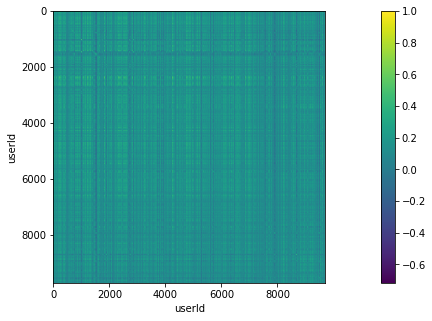

In [37]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(films_correlation);
plt.xlabel('userId')
plt.ylabel('userId')
plt.colorbar()
plt.show()

Veamos las películas más correlacionadas con la película ejemplo *Toy Story*:

Definimos una función que nos relacione una película ejemplo.

Tenemos que tener en cuenta las veces que se han valorados las películas, pues solo serán válidas las películas que hayan sido valoradas >100 veces. (El promedio de una película valorada muchas veces tiene más sentido estadístico que el promedio de una película evaluada pocas veces). Añadimos la condición de que $count\_rating>100$ y mostramos por pantalla las películas más relacionadas con la película ejemplo: Toy Story.

In [38]:
def PeliculasRelacionadas(pelicula,n):
    
    # Cogemos los datos de la películas ejemplo:
    pelicula_ejemplo = df_movies_genres[pelicula]
    
    # Hacemos uso del método corrwith() para ver
    # las películas correlacionadas con la pelicula ejemplo.
    peliculas_similares = df_movies_genres.corrwith(pelicula_ejemplo)
    
    # Creamos un DataFrame con los datos. Eliminamos la película ejemplo.
    # No tiene sentido guardarla.
    df_peliculas_similares = pd.DataFrame(peliculas_similares, columns=['Correlation']).drop(pelicula, axis=0)
    
    # Añadimos las veces que se han puntuado las películas
    df_peliculas_similares = df_peliculas_similares.join(count_mean_ratings_film[['count_rating', 'title']].set_index('title'), on='title')
    
    # Hacemos una purga con la condicion count_rating>100:
    df_peliculas_similares = df_peliculas_similares.sort_values(['Correlation', 'count_rating'], ascending=False).reset_index()
    
    # Devolvemos las n películas más similares:
    return df_peliculas_similares[df_peliculas_similares['count_rating']>100][['title', 'Correlation']].sort_values('Correlation',ascending=False).reset_index(drop=True).head(n)

In [39]:
PeliculasRelacionadas(pelicula='Toy Story (1995)', n=8)

,title,Correlation
0,"Monsters, Inc. (2001)",1.000000
1,Shrek (2001),0.879664
2,Finding Nemo (2003),0.864099
3,Aladdin (1992),0.728571
4,"Incredibles, The (2004)",0.728571
5,Monty Python and the Holy Grail (1975),0.724569
6,Jumanji (1995),0.724569
7,Harry Potter and the Sorcerer's Stone (a.k.a. ...,0.724569


Las películas que nos recomienda nuestro recomendador teniendo como ejemplo Toy Story son:
- Monster, Inc.
- Shrek
- Finding Nemo
- ...

De dibujos animados, orientadas a niños, de fantasía... justo los géneros que presenta la película ejemplo Toy Story.

# 6. Filtrado colaborativo de popularidad

Nuestro objetivo en este apartado es crear la matriz que nos muestre la relación/similitud entre usuarios. Para ello haremos uso de la similitud por el coseno, el cual proyecta un usuario sobre otro. Si la proyección es máxima (=1) la similitud es perfecta, en cambio si los vectores son perpendiculares (=0) no existe relación entre los dos usuarios estudiados.

Recordamos la tabla de las puntuaciones a cada película: 

In [40]:
movieratings

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


Si quisiéramos ver la relación de un usuario ejemplo (en este caso el usuario 1) con los demás usuarios, se debe proceder como hicimos con las películas:

Definiremos otra función que relacione los usuarios. (Realmente es el método es muy parecido al de las películas)

In [41]:
def UsuariosRelacionados(user,n):
    
    # Cogemos los datos del usuario ejemplo:
    user_ejemplo = movieratings.loc[user]
    
    # En este caso tenemos que especificar axis=1, 
    # debido a la distribución de la tabla.
    users_similares = movieratings.corrwith(user_ejemplo, axis=1)
    
    # Creamos un DataFrame con los datos. Eliminamos el usuario ejemplo.
    # No tiene sentido guardarlo.
    df_users_similares = pd.DataFrame(users_similares, columns=['Correlation']).drop(user, axis=0)
    
    # Devolvemos los n usuarios más similares:
    return df_users_similares.sort_values('Correlation',ascending=False).reset_index().head(n)

In [42]:
UsuariosRelacionados(user=1,n=5)

,userId,Correlation
0,266,0.344932
1,313,0.333802
2,368,0.323954
3,57,0.323860
4,39,0.320081


# 7. Recomendador de películas según la valoración de los usuarios

Partimos del mismo dataset que en el apartado 4.

Comprobamos la cantidad de ceros que tenemos en el dataset:

In [43]:
values_rating = movieratings.values
sparsity = float(len(values_rating.nonzero()[0]))
sparsity /= (values_rating.shape[0] * values_rating.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.71%


1.71% de ceros en nuestro dataset. (No parecen muchos).

Dividimos nuestros datos en train y test para poder saber cómo de preciso es nuestro recomendador.

In [44]:
# Dividimos en train y test:
ratings_train , ratings_test = train_test_split(values_rating,\
                                test_size = 0.2,
                                random_state=123,
                                shuffle=False)

print(ratings_train.shape,'\n',ratings_test.shape)

(488, 9685) 
 (122, 9685)


Creamos la **matriz de similitud entre usuarios** mediante el coeficiente de correlación de Pearson. (En la siguiente celda está comentadas las líneas donde se calcula la matriz de similitud mediante la distancia del coseno. Al final se decidió por el método de Pearson porque en la literatura se dice, resumidamente, que a este método no le afecta el comportamiento de los usuarios. Además al evaluar el recomendador, el método de Pearson conlleva una mejoría de unas décimas).

In [45]:
# La función cosine_distances() calcula la distancia, 
# para conseguir la similaridad del coseno hay que restar 1.

# similarity_matrix = pd.DataFrame(1 - cosine_distances(movieratings),\
#                                  index = movieratings.index,\
#                                  columns=movieratings.index)

# similarity_matrix

# Método de Pearson:
similarity_matrix = pd.DataFrame(np.corrcoef(movieratings, \
                                             rowvar=True),\
                                 columns = movieratings.index,\
                                 index = movieratings.index)
similarity_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.019368,0.053028,0.176848,0.120833,0.104320,0.143731,0.128512,0.055231,-0.000369,...,0.067291,0.149882,0.186831,0.056472,0.134333,0.121800,0.254137,0.262119,0.085401,0.098517
2,0.019368,1.000000,-0.002605,-0.003835,0.013169,0.016219,0.021543,0.023736,-0.003462,0.061857,...,0.200915,0.010864,-0.004097,-0.005366,-0.007951,0.011226,0.005784,0.032674,0.024360,0.089273
3,0.053028,-0.002605,1.000000,-0.004583,0.001875,-0.004611,-0.005656,0.001690,-0.003123,-0.005524,...,0.000238,-0.000607,0.011153,-0.004842,0.003650,-0.003315,0.012859,0.008041,-0.002975,0.015892
4,0.176848,-0.003835,-0.004583,1.000000,0.120987,0.065625,0.100543,0.054200,0.002380,0.015552,...,0.073936,0.114230,0.281756,0.039645,0.065415,0.164679,0.115050,0.116722,0.023896,0.062327
5,0.120833,0.013169,0.001875,0.120987,1.000000,0.294112,0.101698,0.426566,-0.004202,0.023442,...,0.062736,0.414916,0.095332,0.254099,0.141045,0.090089,0.145735,0.122553,0.258277,0.040284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.121800,0.011226,-0.003315,0.164679,0.090089,0.047270,0.172381,0.081839,0.057912,0.054731,...,0.156319,0.084069,0.224297,0.035119,0.106573,1.000000,0.115840,0.188024,0.052311,0.093360
607,0.254137,0.005784,0.012859,0.115050,0.145735,0.142086,0.173241,0.178105,0.003222,-0.004871,...,0.081194,0.187537,0.172895,0.126220,0.101066,0.115840,1.000000,0.258141,0.142506,0.098342
608,0.262119,0.032674,0.008041,0.116722,0.122553,0.137781,0.305363,0.175865,0.086169,0.048250,...,0.138411,0.173970,0.164179,0.133643,0.144756,0.188024,0.258141,1.000000,0.109511,0.248617


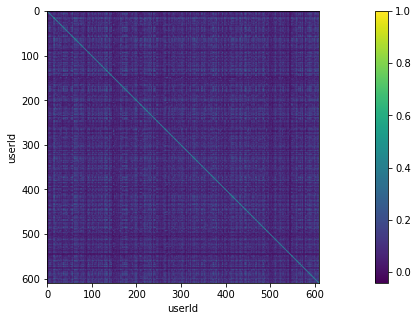

In [46]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(similarity_matrix);
plt.xlabel('userId')
plt.ylabel('userId')
plt.colorbar()
plt.show()

In [47]:
# Separamos las filas de train y test de la matriz de similitud:
similarity_matrix_train = similarity_matrix.loc[0:ratings_train.shape[0]\
                                               ,0:ratings_train.shape[0]]

similarity_matrix_test = similarity_matrix.loc[ratings_train.shape[0]+1:similarity_matrix.shape[0]\
                                              ,ratings_train.shape[0]+1:similarity_matrix.shape[0]]

print(similarity_matrix_train.shape,'\n',similarity_matrix_test.shape)

(488, 488) 
 (122, 122)


Para calcular el rating $R_U$ que un usuario $U$ daría a un item $I$ (no valorado por él mismo), lo podemos calcular mediante la media ponderada de las puntuaciones que han dado los demás usuarios (a ese mismo item) multiplicado por la similitud que tiene el usuario $U$ con los demás usuarios ($S_u$).

Básicamente es coger una fila o columna de la matriz de similitudes (es simétrica, así que da igual fila o columna) y multiplicarla por la columna , que representa al item $I$, de la matriz de las puntuaciones. A continuación, normalizamos por la fila de la matriz de similitudes.

(Con la media ponderada, estamos dando más importancia a las puntuaciones que hagan los usuarios con mayor similitud).

\begin{equation}
    R_U = \frac{\sum_{u=1}^{n} R_u * S_u}{\sum_{u=1}^{n} S_u}
\end{equation}

Creamos una matriz con las predicciones de la valoración de los usuarios a cada película.

In [48]:
# En este caso no estamos consiguiendo un solo valor de rating,
# sino todas las puntuaciones que haría el usuario.
# Estamos rellenando toda la matriz del train.
users_predictions = similarity_matrix_train.dot(ratings_train) / np.array([np.abs(similarity_matrix_train).sum(axis=1)]).T

# Le añadimos el nombre a las columnas:
users_predictions.columns = movieratings.columns
users_predictions

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.015230,0.015806,0.003692,0.006470,0.003159,0.121954,0.008536,0.212046,0.041705,...,0.005389,0.057518,0.022842,0.011429,-0.000576,0.204237,0.159771,0.019905,0.297789,0.0
2,0.0,0.010882,0.008637,-0.000876,-0.001667,0.005073,0.031173,0.000092,0.441999,0.027354,...,0.005862,0.054963,0.024017,0.005455,0.014093,0.112392,0.151620,0.030890,0.147292,0.0
3,0.0,0.019219,0.070595,-0.001624,-0.002637,-0.002072,0.152658,-0.008124,-0.041504,0.008233,...,0.001707,0.031783,0.016523,0.017891,-0.003796,0.148355,0.034729,0.018083,0.144397,0.0
4,0.0,0.013313,0.015274,0.007125,0.017718,0.000957,0.107857,0.015721,0.213333,0.035203,...,0.003660,0.038493,0.008726,0.005208,-0.000468,0.221191,0.132263,0.013950,0.241118,0.0
5,0.0,0.007400,0.008739,0.000709,0.002232,0.001171,0.058141,0.006006,0.125601,0.017959,...,0.001701,0.032979,0.009661,0.004195,-0.000375,0.086230,0.083355,0.013219,0.118759,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0.0,0.012518,0.013619,0.003852,0.006920,0.003529,0.108330,0.008741,0.412802,0.050508,...,0.005804,0.076985,0.027484,0.010013,0.000820,0.163006,0.223797,0.038620,0.235063,0.0
485,0.0,0.006041,0.006707,-0.000327,0.001725,0.001432,0.047437,0.003615,0.094868,0.019811,...,0.002486,0.024466,0.011395,0.004343,-0.000281,0.078376,0.077490,0.011108,0.103008,0.0
486,0.0,0.006652,0.007392,0.001655,0.003229,0.001742,0.052687,0.003202,0.114456,0.021416,...,0.002031,0.032309,0.014836,0.006351,-0.000358,0.094716,0.093129,0.011430,0.114448,0.0


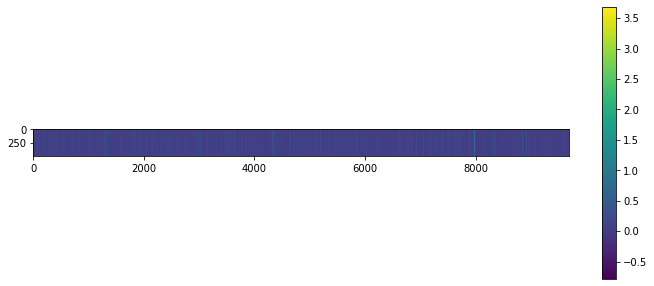

In [49]:
plt.rcParams['figure.figsize'] = (12.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

### Ponemos a prueba las predicciones:

Buscamos cuales son las películas que más le gustarán a un usuario ejemplo:

In [50]:
# Seleccionamos ejemplo:
usuario_ejemplo = 5

# Cogemos las predicciones del usuario ejemplo:
# Lo ordenamos para ver los valores más altos.
predicciones = pd.DataFrame(users_predictions.loc[usuario_ejemplo].sort_values(ascending=False).head(6)).reset_index()
predicciones.columns = ['title', 'Predicted Rating']
predicciones

,title,Predicted Rating
0,Pulp Fiction (1994),3.104421
1,"Shawshank Redemption, The (1994)",3.079185
2,Forrest Gump (1994),2.882621
3,Braveheart (1995),2.534023
4,"Silence of the Lambs, The (1991)",2.472076
5,Apollo 13 (1995),2.311805


### Medimos el error del recomendador:

Mediremos el error mediante el error por mínimos cuadrados: (mean_squared_error)

In [51]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [52]:
print('Training error: ',get_mse(users_predictions.values, ratings_train))

Training error:  9.428676157905187


In [53]:
# Realizo las predicciones para el test set
users_predictions_test = similarity_matrix.dot(values_rating) / np.array([np.abs(similarity_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test.loc[ratings_train.shape[0]+1:similarity_matrix.shape[0],:]

print('Testing error: ',get_mse(users_predictions_test.values, ratings_test))

Testing error:  9.214272688834477


El método empleado nos arroja un error en los datos de entrenamiento de 9.43 y un error en los datos de testeo de 9.21. Ambos resultados son muy cercanos lo que puede indicar que no está habiendo overfitting.